In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import sys
import glob
import random

In [2]:
# Imports from object detection API
from utils import label_map_util
from utils import visualization_utils as vis_util

In [3]:
%matplotlib inline

# Traffic Light Detection/Classification

## Utility Functions

In [4]:
def load_graph(graph_file, use_xla=False):
    jit_level = 0
    config = tf.ConfigProto()
    if use_xla:
        jit_level = tf.OptimizerOptions.ON_1
        config.graph_options.optimizer_options.global_jit_level = jit_level

    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)
        tf.import_graph_def(gd, name='')
        return sess, sess.graph

In [5]:
# From object_detection_tutorial.ipynb in tensorflow's Object Detection API
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks,
                                                                                      detection_boxes,
                                                                                      image.shape[0],
                                                                                      image.shape[1])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
                
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
                
    return output_dict

## Load Graph & Corresponding Labels

In [6]:
graph_file = 'models/retrained/ssd_inception_v2_coco_11_06_2017_retrained_real/frozen/frozen_inference_graph.pb'
# graph_file = 'models/retrained/ssd_inception_v2_coco_2017_11_17_retrained_real/frozen/frozen_inference_graph.pb'
sess, graph = load_graph(graph_file)

In [25]:
with graph.as_default():
    res = [n.name for n in tf.get_default_graph().as_graph_def().node]
pd.Series(res)

0                                                   Const
1                                            image_tensor
2                                                 ToFloat
3                                  Preprocessor/map/Shape
4                    Preprocessor/map/strided_slice/stack
5                  Preprocessor/map/strided_slice/stack_1
6                  Preprocessor/map/strided_slice/stack_2
7                          Preprocessor/map/strided_slice
8                            Preprocessor/map/TensorArray
9               Preprocessor/map/TensorArrayUnstack/Shape
10      Preprocessor/map/TensorArrayUnstack/strided_sl...
11      Preprocessor/map/TensorArrayUnstack/strided_sl...
12      Preprocessor/map/TensorArrayUnstack/strided_sl...
13      Preprocessor/map/TensorArrayUnstack/strided_slice
14        Preprocessor/map/TensorArrayUnstack/range/start
15        Preprocessor/map/TensorArrayUnstack/range/delta
16              Preprocessor/map/TensorArrayUnstack/range
17      Prepro

In [7]:
LABEL_DIR = 'data'
LABEL_FILE = 'label_map.pbtxt'

label_file = os.path.join(LABEL_DIR, LABEL_FILE)

category_index = label_map_util.create_category_index_from_labelmap(label_file)

## Examine Test Image

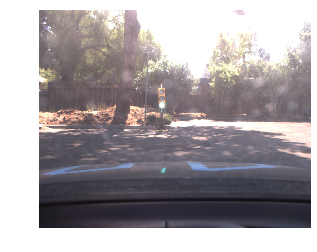

In [8]:
IMAGE_DIR = 'data/data/real_training_data'
IMAGE_CLASS = 'green'
SAMPLE_IMAGE_FILE = 'left0352.jpg'

imfile = os.path.join(IMAGE_DIR, IMAGE_CLASS, SAMPLE_IMAGE_FILE)

image = cv2.imread(imfile)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.axis('off')
plt.imshow(image)

## Run Detection

In [9]:
output_dict = run_inference_for_single_image(image, graph)

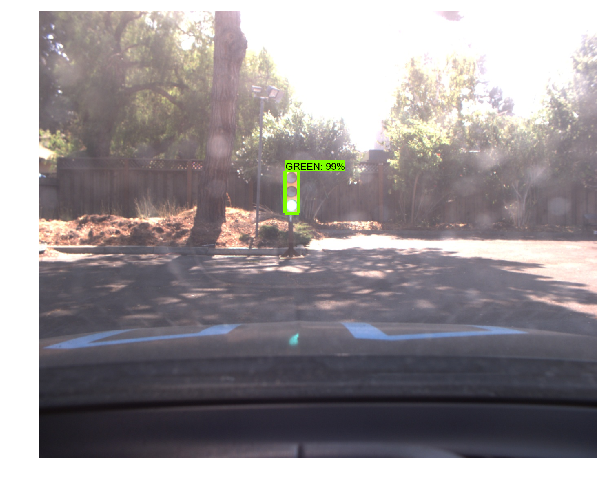

In [10]:
image_draw = np.copy(image)
vis_util.visualize_boxes_and_labels_on_image_array(
    image_draw,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image_draw)

## Timing Traffic Light Classification

Prepare graph and input dicts for tf session and time how long it takes the graph to process a single image

In [11]:
def inference(sess, image, tensor_dict):
    # Run inference
    output_dict = sess.run(tensor_dict,
                         feed_dict={image_tensor: np.expand_dims(image, 0)})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    
    return output_dict

In [12]:
with graph.as_default():    
    # Get handles to input and output tensors
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    if 'detection_masks' in tensor_dict:

        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])

        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks,
                                                                              detection_boxes,
                                                                              image.shape[0],
                                                                              image.shape[1])
        detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)

        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)

    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    res = []
    with tf.Session() as sess:
        data_types = ['green','red','yellow','unidentified','nolight']
        for data_type in data_types:
            for image_file in glob.glob('data/data/real_training_data/'+data_type+'/*.jpg'):
                image = cv2.imread(image_file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                res.append(inference(sess, image, tensor_dict))

In [13]:
correct = 0
incorrect = 0
count = 0
for i,data_type in enumerate(data_types):
    for j,image_file in enumerate(glob.glob('data/data/real_training_data/'+data_type+'/*.jpg')):
        if category_index[res[count]['detection_classes'][0]]['name'] == data_type.upper():
            correct +=1
        else:
            incorrect +=1
        count += 1
correct/(correct+incorrect)

0.9042253521126761